In [95]:
import sys
import os

import numpy as np 
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset, MyWeakDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

In [32]:
cfg = {
    "lbl": "train_4_standard_best",
    "desc": "predicts point of size 4 from standard scaled train data",
    "data_suffix": "_standard",
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 10000,
    "betas": [0, 0.99],
    "lr": 1e-3,
    "batch_size": 256,
    "mini_batch_size": 410,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "metrics_freq": 10,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_pred_rows": 410,
    "num_reps": 10000,
    "finetune": True,
    "from_ckpt": True,
    "from_epoch": 2
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':1000,
    'n_samples_weak':250,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_test'],
    'n_features':20,
    'n_informative':20,
    'n_targets':2,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [33]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])

train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"])

### GAN Regression

In [61]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)
X_train_torch = torch.Tensor(X_train).to(cfg["device"])

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

In [62]:
X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

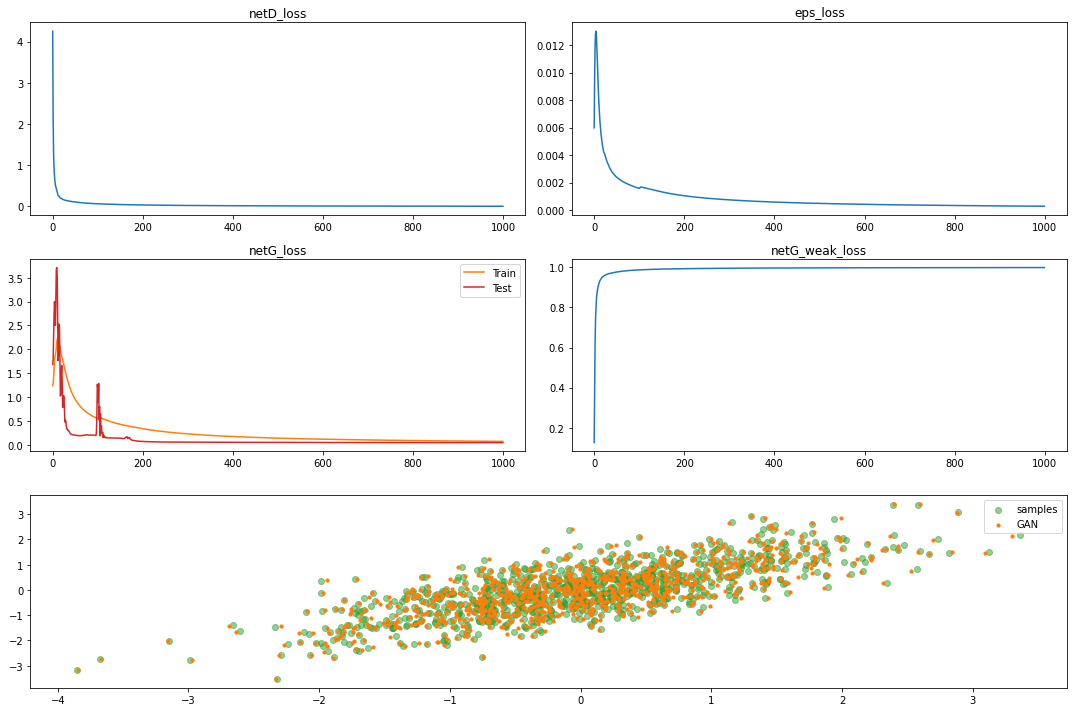

In [63]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()

            grad_loss = ((grads.norm(2, dim=-1)) ** 2).mean()
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())
            meters['netG_weak_loss'].update(grad_loss.item())

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%2500:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_train_torch,
                              torch.zeros(y_train.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise).cpu()
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

## Weak Regression
### Normal Regression, Small Train Set

In [175]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 10000,
    "batch_size": 50,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-4,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':50,
    'n_samples_weak':950,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_weak']\
                +cfg_dataset['n_samples_test'],
    'n_features':20,
    'n_informative':20,
    'n_targets':2,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [176]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])

X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyWeakDataset(X_train, y_train, X_weak, batch_size=cfg["batch_size"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"])

In [177]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

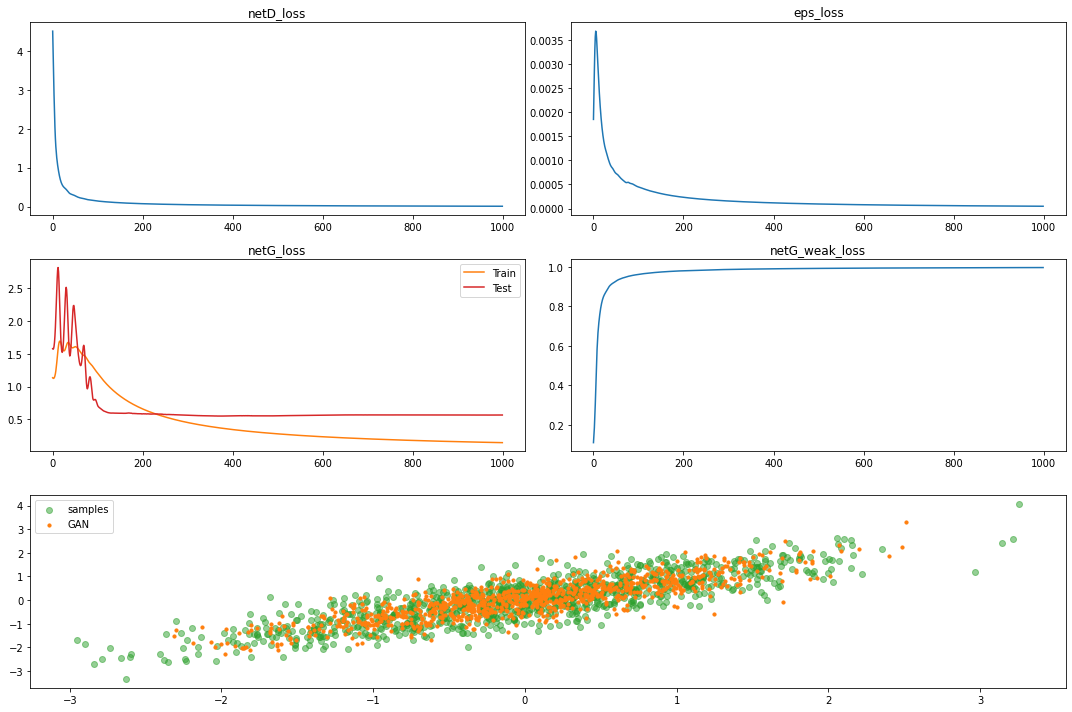

In [100]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()

            grad_loss = ((grads.norm(2, dim=-1)) ** 2).mean()
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())
            meters['netG_weak_loss'].update(grad_loss.item())

            #fake_weak = netG(X_batch_weak.requires_grad_(True))
            #grads = torch.autograd.grad(
            #    outputs=fake_weak.mean(),
            #    inputs=X_batch_weak,
            #    create_graph=True,
            #    retain_graph=True,
            #)[0]

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()

    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

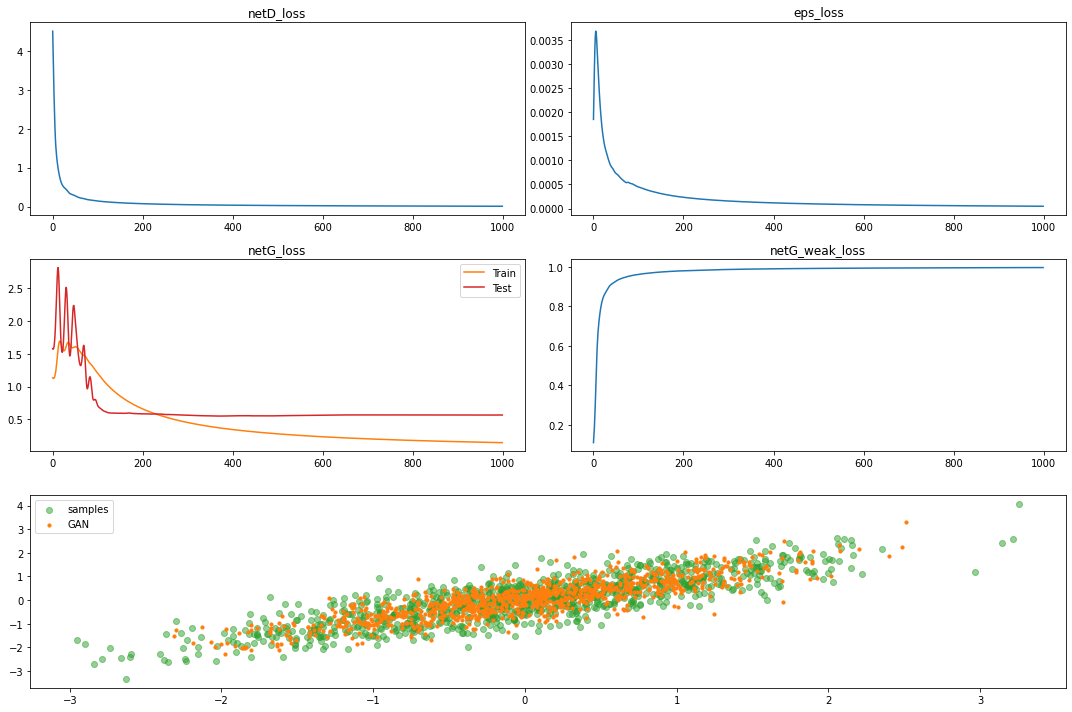

In [103]:
losses_small = losses
with torch.no_grad():
    noise = torch.cat([X_test_torch,
                          torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
    y_pred = netG(noise)
    l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
    axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")
y_pred_small = y_pred.cpu().numpy()

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

ax1.set_title("netD_loss")
ax1.plot(losses_small[0])

ax2.set_title("eps_loss")
ax2.plot(losses_small[1])

ax3.set_title("netG_loss")
ax3.plot(losses_small[2], label="Train", color="tab:orange")

ax4.set_title("netG_weak_loss")
ax4.plot(losses_small[3])


gs = axs[2, 1].get_gridspec()
# remove the underlying axes
for ax in axs[2, :]:
    ax.remove()
axbig = fig.add_subplot(gs[2, :])
axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
axbig.scatter(y_pred_small[:, 0], y_pred_small[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")
axbig.legend()

ax3.plot(losses_small[4], label="Test", color="tab:red")
ax3.legend()
fig.tight_layout()

plt.show()

### Normal Regression, Weak regularisation

In [184]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 10000,
    "batch_size": 50,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1,
    "display_freq": 10,
    "schedule_freq": 2000,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2
}

In [185]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])

X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyWeakDataset(X_train, y_train, X_weak, batch_size=cfg["batch_size"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"])

In [186]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-2)
optimD = Adam(netD.parameters(), lr=1e-2)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

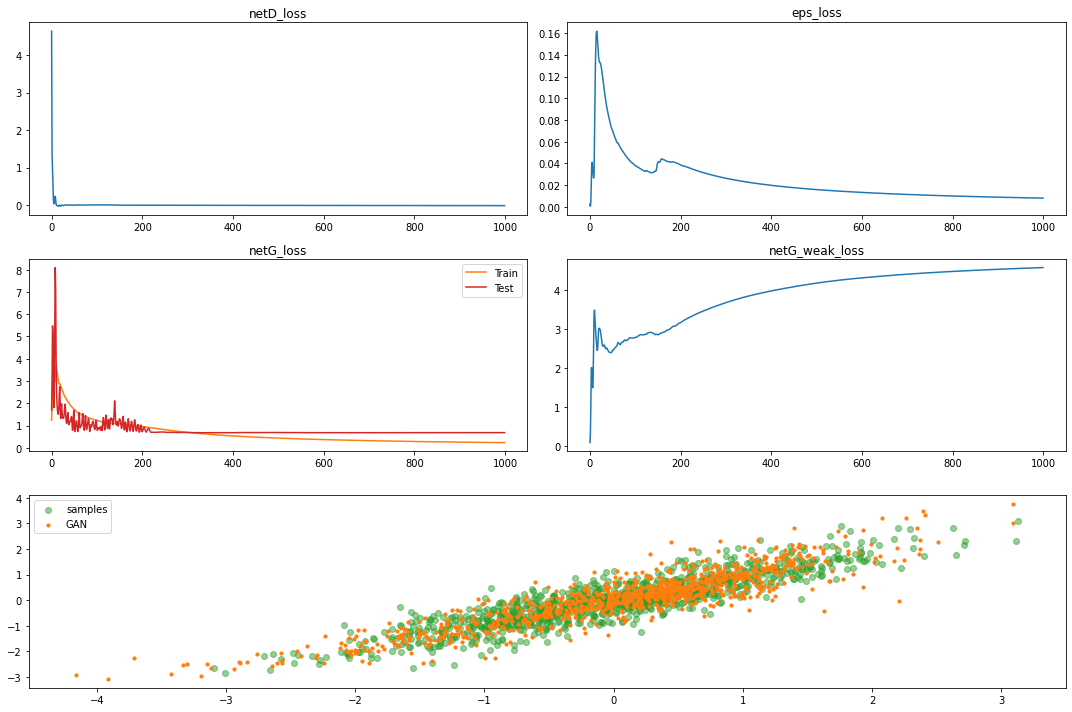

In [165]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_batch_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            X_batch_weak = X_batch_weak.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            with torch.no_grad():
                noise_weak = torch.cat([X_batch_weak,
                                  torch.randn((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                 netG(noise_weak)], axis=1)

            grads = torch.autograd.grad(
                outputs=netG(fake_weak.requires_grad_(True)).sum(),
                inputs=fake_weak,
                create_graph=True,
                retain_graph=True,
            )[0]

            grad_loss = (grads**2).sum(axis=1).mean()
            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss + cfg["w_weak"]*grad_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

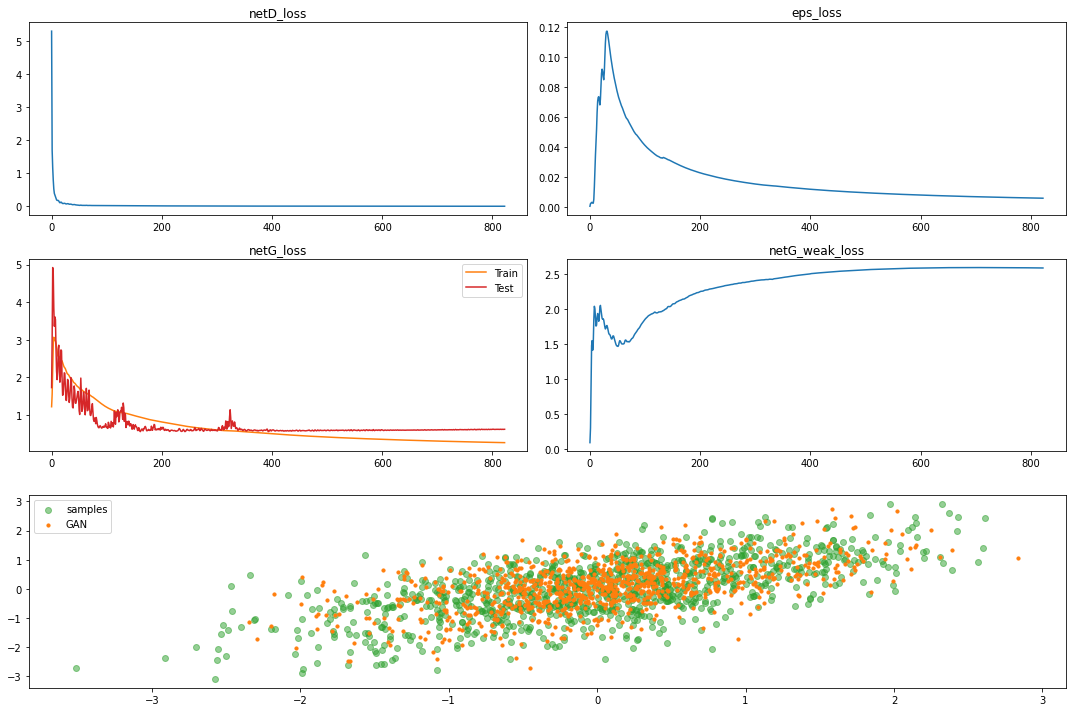

In [ ]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_batch_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            X_batch_weak = X_batch_weak.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            with torch.no_grad():
                noise_weak = torch.cat([X_batch_weak,
                                  torch.randn((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                 netG(noise_weak)], axis=1)

            grads = torch.autograd.grad(
                outputs=netG(fake_weak.requires_grad_(True)).sum(),
                inputs=fake_weak,
                create_graph=True,
                retain_graph=True,
            )[0]

            grad_loss = (grads**2).sum(axis=1).mean()
            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss + cfg["w_weak"]*grad_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

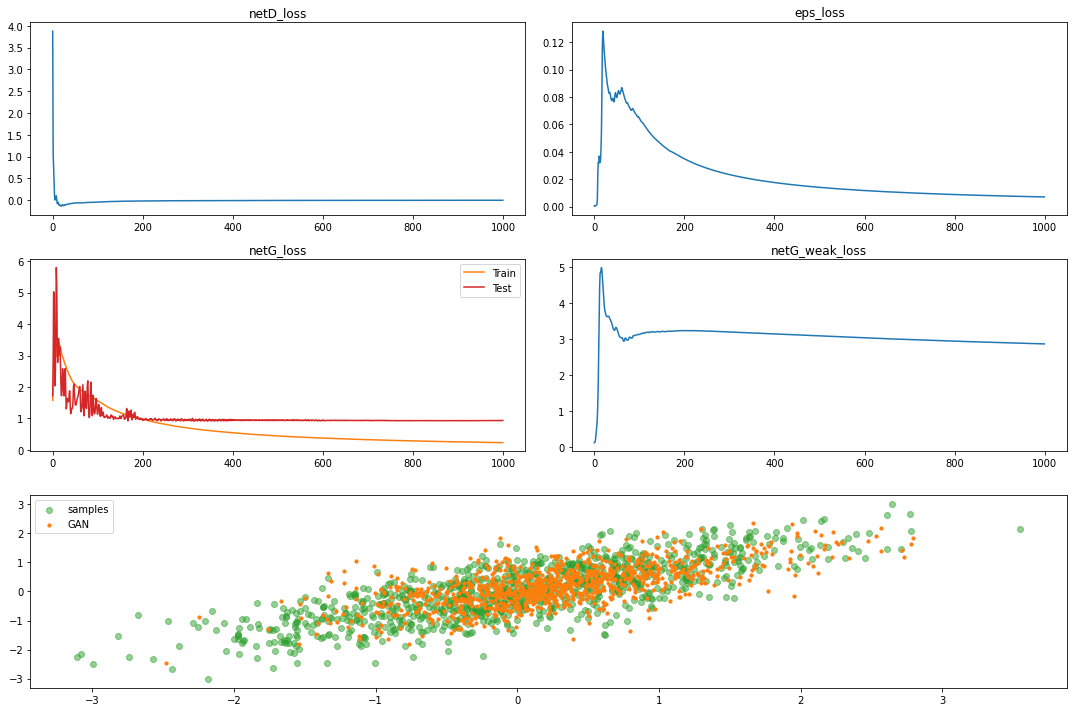

In [174]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_batch_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            X_batch_weak = X_batch_weak.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            with torch.no_grad():
                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            grads = torch.autograd.grad(
                outputs=netG(fake_weak.requires_grad_(True)).sum(),
                inputs=fake_weak,
                create_graph=True,
                retain_graph=True,
            )[0]

            grad_loss = (grads**2).sum(axis=1).mean()
            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss + cfg["w_weak"]*grad_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

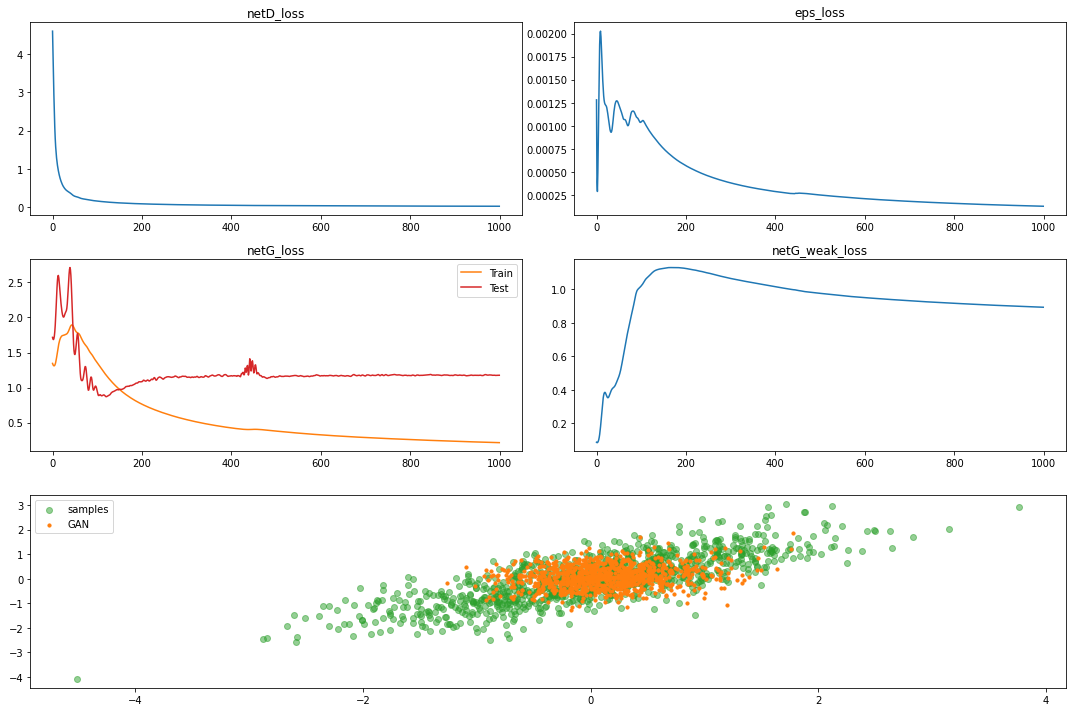

In [178]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_batch_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            X_batch_weak = X_batch_weak.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            with torch.no_grad():
                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            grads = torch.autograd.grad(
                outputs=netG(fake_weak.requires_grad_(True)).sum(),
                inputs=fake_weak,
                create_graph=True,
                retain_graph=True,
            )[0]

            grad_loss = (grads**2).sum(axis=1).mean()
            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss + cfg["w_weak"]*grad_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

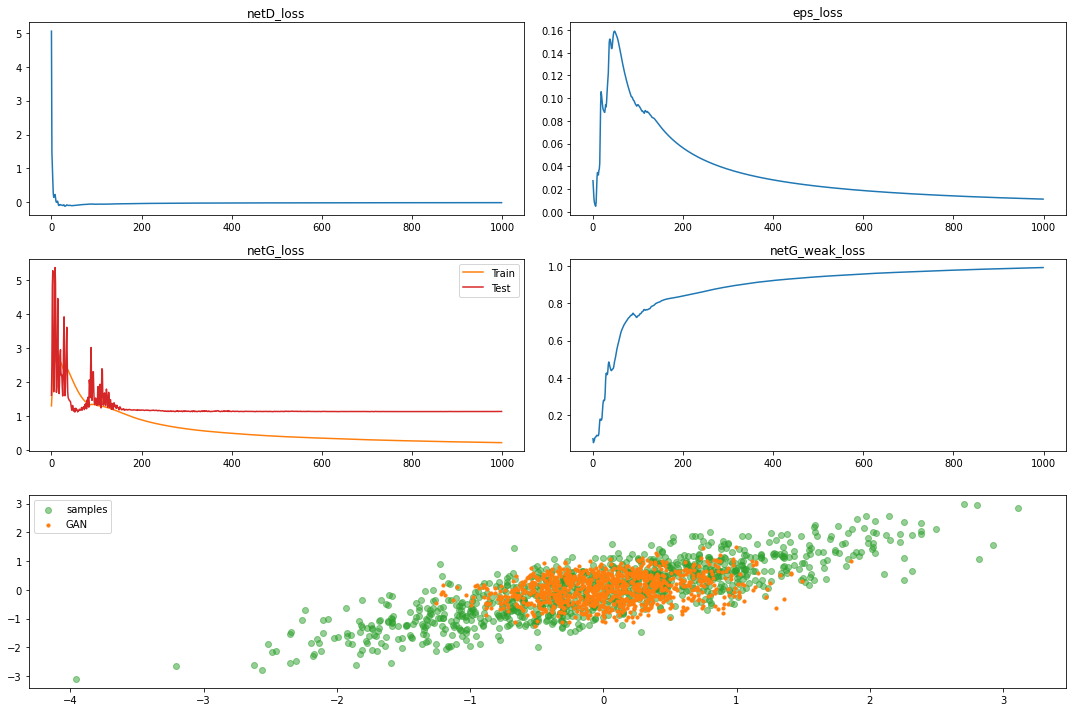

In [183]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_batch_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            X_batch_weak = X_batch_weak.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            with torch.no_grad():
                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            grads = torch.autograd.grad(
                outputs=netG(fake_weak.requires_grad_(True)).sum(),
                inputs=fake_weak,
                create_graph=True,
                retain_graph=True,
            )[0]

            grad_loss = (grads**2).sum(axis=1).mean()
            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss + cfg["w_weak"]*grad_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()

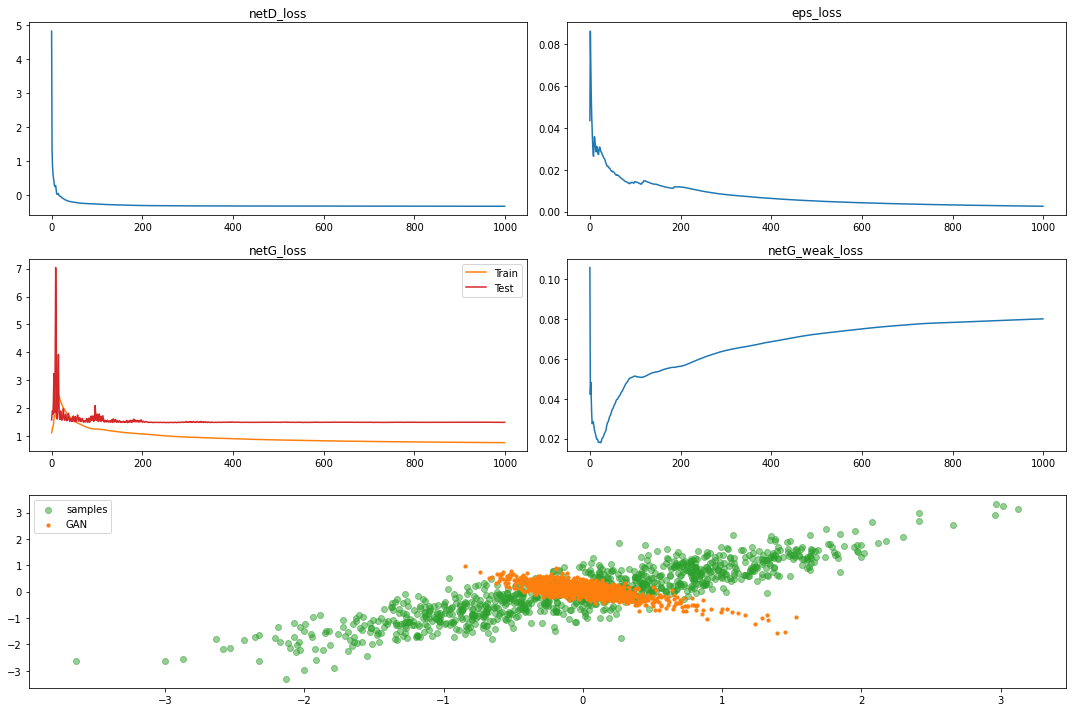

In [187]:
try:
    losses = [[], [], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, X_batch_weak, y_batch in train_loader:
            optimD.zero_grad()
            X_batch = X_batch.to(cfg['device'])
            y_batch = y_batch.to(cfg['device'])
            X_batch_weak = X_batch_weak.to(cfg['device'])
            real = torch.cat([X_batch, y_batch], axis=1)

            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            
            with torch.no_grad():
                noise = torch.cat([X_batch,
                                      torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()
            
            with torch.no_grad():
                noise_weak = torch.cat([X_batch_weak,
                                    torch.zeros((X_batch_weak.shape[0], y_train.shape[1]), device=cfg['device'])], axis=1)
                fake_weak = torch.cat([X_batch_weak,
                                    netG(noise_weak)], axis=1)

            grads = torch.autograd.grad(
                outputs=netG(fake_weak.requires_grad_(True)).sum(),
                inputs=fake_weak,
                create_graph=True,
                retain_graph=True,
            )[0]

            grad_loss = (grads**2).sum(axis=1).mean()
            meters['netG_weak_loss'].update(grad_loss.item())
            
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())

            netG_loss_total = netG_loss + cfg["w_weak"]*grad_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % cfg["display_freq"]:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)
            fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]
            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2], label="Train", color="tab:orange")

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])


            gs = axs[2, 1].get_gridspec()
            # remove the underlying axes
            for ax in axs[2, :]:
                ax.remove()
            axbig = fig.add_subplot(gs[2, :])
            axbig.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")
            with torch.no_grad():
                noise = torch.cat([X_test_torch,
                                      torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
                y_pred = netG(noise)
                l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
                axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

            axbig.legend()
            
            losses[4].append(l2_test)
            ax3.plot(losses[4], label="Test", color="tab:red")
            ax3.legend()
            fig.tight_layout()

            plt.show()            
            
        if not e%cfg["schedule_freq"]:
            schedD.step()
            schedG.step()
            
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2], label="Train", color="tab:orange")

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])


    gs = axs[2, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[2, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[2, :])
    axbig.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, zorder=-1, label="samples", color="tab:green")

    with torch.no_grad():
        noise = torch.cat([X_test_torch,
                              torch.zeros(y_test.shape, device=cfg['device'])], axis=1)
        y_pred = netG(noise)
        l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()
        axbig.scatter(y_pred.cpu().numpy()[:, 0], y_pred.cpu().numpy()[:, 1], s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

    axbig.legend()
    
    losses[4].append(l2_test)
    ax3.plot(losses[4], label="Test", color="tab:red")
    ax3.legend()
    fig.tight_layout()

    plt.show()